## Deepsolar Inference pipeline

The pipeline has two steps:
1. Detecting if an image has PV or not (Binary classification)
2. Detecting the relevant (PV) pixels (Semantic Segmentation)

Notes:
1. Works best on rooftop solar PV installations.
2. Resolution should be zoom >= 19 from [Google Maps zoom](https://developers.google.com/maps/documentation/maps-static/start#Zoomlevels) reference. 
3. Input image size: 256 by 256, RGB channels.

In [1]:
import transformers
import shutil
import os
import cv2
import time
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
import argparse
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import Normalize
from transformers import ViTForImageClassification, ViTImageProcessor
from dataloader_file import ImageFolder
from transformers import SegformerImageProcessor

random.seed(42)
np.random.seed(42)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cpu


### ViT Detection Model

In [3]:
class LoRAConv1DWrapper(nn.Module):
    def __init__(self, conv1dmodule: nn.Module, lora_rank: int):
        super().__init__()

        self.base_module = conv1dmodule
        in_features = self.base_module.weight.shape[0]
        out_features = self.base_module.weight.shape[1]

        self.lora_A = nn.Parameter(torch.empty((in_features, lora_rank)))  # 3072, 4
        self.lora_B = nn.Parameter(torch.empty((out_features, lora_rank)))  # 4, 1024

        nn.init.zeros_(self.lora_B).to(device)
        nn.init.normal_(self.lora_A).to(device)

    def forward(self, x):
        Wx = self.base_module(x)  # 1, 69, 3072
        BAt = (self.lora_B @ self.lora_A.T).to(device)
        # ABx = x @ self.lora_A
        BAtx = x @ BAt
        out = Wx + BAtx
        return out


In [4]:
model_dir = '../detection_model/pytorch_model.bin'

feature_extractor = ViTImageProcessor.from_pretrained("facebook/vit-mae-large")
model = ViTForImageClassification.from_pretrained("facebook/vit-mae-large", num_labels=2,
                                                  ignore_mismatched_sizes=True)
model = model.to(device)
mode = 'lora'
if mode.startswith('lora'):
    for m in model.vit.encoder.layer:
        m.output.dense = LoRAConv1DWrapper(m.output.dense, 4)
        m.intermediate.dense = LoRAConv1DWrapper(m.intermediate.dense, 4)

model.load_state_dict(torch.load(model_dir, map_location=torch.device(device)))

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/vit-mae-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

### Test Function

In [5]:
def metrics(stats):
        """stats: {'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN}
        return: must be a single number """
        precision = (stats['TP'] + 0.00001) * 1.0 / (stats['TP'] + stats['FP'] + 0.00001)
        recall = (stats['TP'] + 0.00001) * 1.0 / (stats['TP'] + stats['FN'] + 0.00001)
        return 0.5*(precision + recall)

def test_model(model, dataloader, metrics, threshold):
    raw_logits = []
    probs_list = []
    img_paths_list = []
    stats = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
    model.eval()
    for inputs, img_paths in tqdm(dataloader):
        inputs = inputs.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            logits = outputs.logits
            probs = F.softmax(logits, dim=1)

            preds = logits[:, 1] >= threshold

        raw_logits.extend(probs)
        probs_list.extend(probs)
        img_paths_list.extend(img_paths)
    return raw_logits, probs_list, img_paths_list

### Dataset

In [6]:
data_dir = '../data_folder'
input_size = 224
batch_size = 512
threshold = 0.5  # threshold probability to identify am image as positive

In [7]:
id2label= {0: 'nopv', 1: 'pv'}
label2id= {'nopv': 0, 'pv': 1}

image_mean, image_std = feature_extractor.image_mean, feature_extractor.image_std
size = feature_extractor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

transform = transforms.Compose([
                 transforms.ToPILImage(),
                 transforms.Resize(input_size),
                 transforms.ToTensor(),
                 normalize
                 ])

transform_cam = transforms.ToPILImage()

In [8]:
dataset_test = ImageFolder(data_dir, transform)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)

In [9]:
logits, probs , img_paths = test_model(model, dataloader_test, metrics, threshold=threshold)

100%|██████████| 1/1 [00:14<00:00, 14.71s/it]


### Detection Inference

Label:  PV


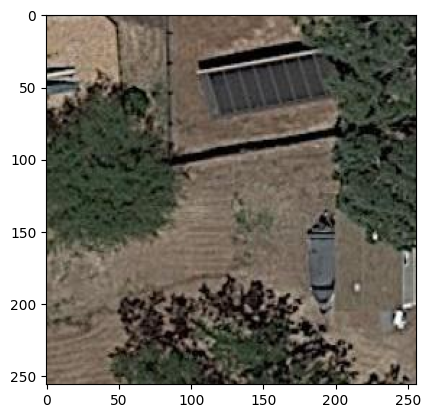

In [47]:
random_pick = np.random.randint(len(img_paths))

img = img_paths[random_pick]
probabilities = probs[random_pick].cpu().numpy()
label = np.argmax(probabilities)
if label == 0:
    string_label = 'no PV'
else:
    string_label = 'PV'
plt.imshow(Image.open(img))
print("Label: ", string_label)

### Segmentation inference

In [48]:
image_processor = SegformerImageProcessor(reduce_labels=False)

In [49]:
seg_model = torch.load('../segmentation_model/segformer_full.pt', map_location=torch.device(device))
seg_model.to(device)
seg_model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [50]:
# prepare the image for the model
img = Image.open(img_paths[random_pick])
img = img.resize((224, 224))
pixel_values = image_processor(img, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [51]:
# forward pass
with torch.no_grad():
  outputs = seg_model(pixel_values=pixel_values)

logits = outputs.logits.cpu()

In [52]:
def color_palette():
    """ palette that maps each class to RGB values."""
    return [[255, 255, 255],[255, 255, 0]]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


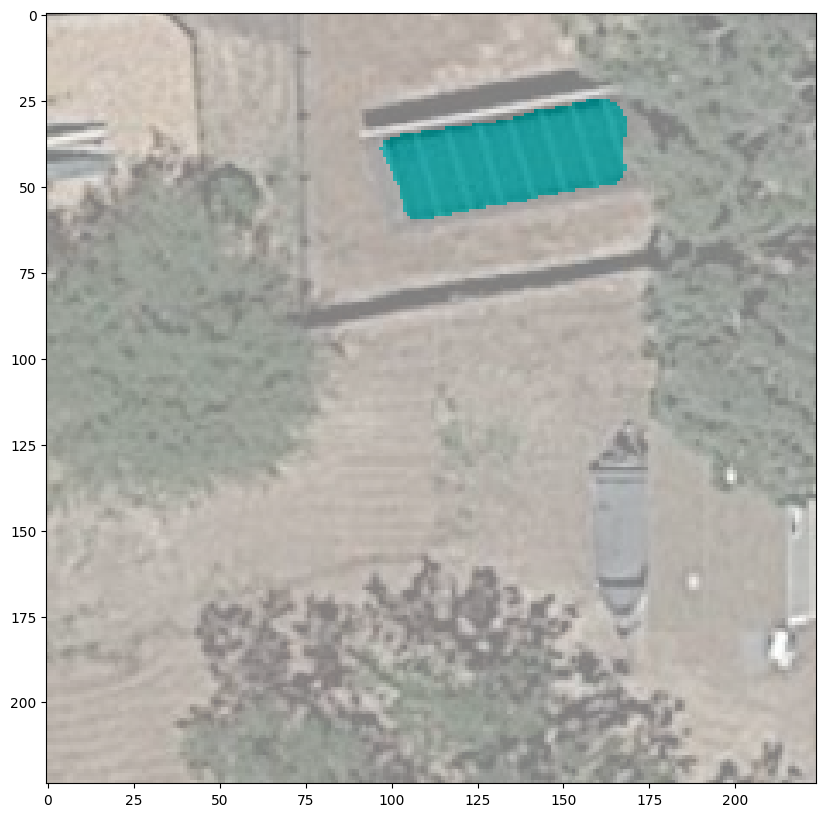

In [53]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[img.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)


color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(color_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(img) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()